### Taskloader
* generates tasks for training. testing and inferencing with Deepsensor models.
* tasks for predictions for : spatial interpolation, forecasting, downscaling

In [23]:
import pandas as pd

In [32]:
import logging

logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.data import DataProcessor
from deepsensor.data.sources import get_ghcnd_station_data, get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import matplotlib.pyplot as plt

# Using the same settings allows use to use pre-downloaded cached data
data_range = ("2016-06-25", "2016-06-30")
extent = "europe"
station_var_IDs = ["TAVG", "PRCP"]
era5_var_IDs = ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"]
auxiliary_var_IDs = ["elevation", "tpi"]
cache_dir = "../../.datacache"

station_raw_df = get_ghcnd_station_data(station_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
auxiliary_raw_ds = get_earthenv_auxiliary_data(auxiliary_var_IDs, extent, "10KM", cache=True, cache_dir=cache_dir)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
aux_ds, land_mask_ds = data_processor([auxiliary_raw_ds, land_mask_raw_ds], method="min_max")
station_df = data_processor(station_raw_df)

In [33]:
from deepsensor.data import TaskLoader

### Initializing a task loader.
##### The Taskloader is initialized with the list of Context and Target variables.
* can be either xarray or pandas.
* assumed to be standardised by dataprocessor.

In [34]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds],
    target=station_df,
    aux_at_targets=aux_ds,
)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'), ('GLDAS_mask',))
Target variable IDs: (('PRCP', 'TAVG'),)
Auxiliary-at-target variable IDs: ('elevation', 'tpi')


### Calling a task loader
* called with a timestamp and either single entries or list of entries of context and target sets.

In [35]:
task = task_loader("2016-06-25", context_sampling="all", target_sampling="all")
print(task)

time: 2016-06-25 00:00:00
ops: []
X_c: [((1, 141), (1, 221)), ((1, 140), (1, 220))]
Y_c: [(3, 141, 221), (1, 140, 220)]
X_t: [(2, 519)]
Y_t: [(2, 519)]
Y_t_aux: (2, 519)



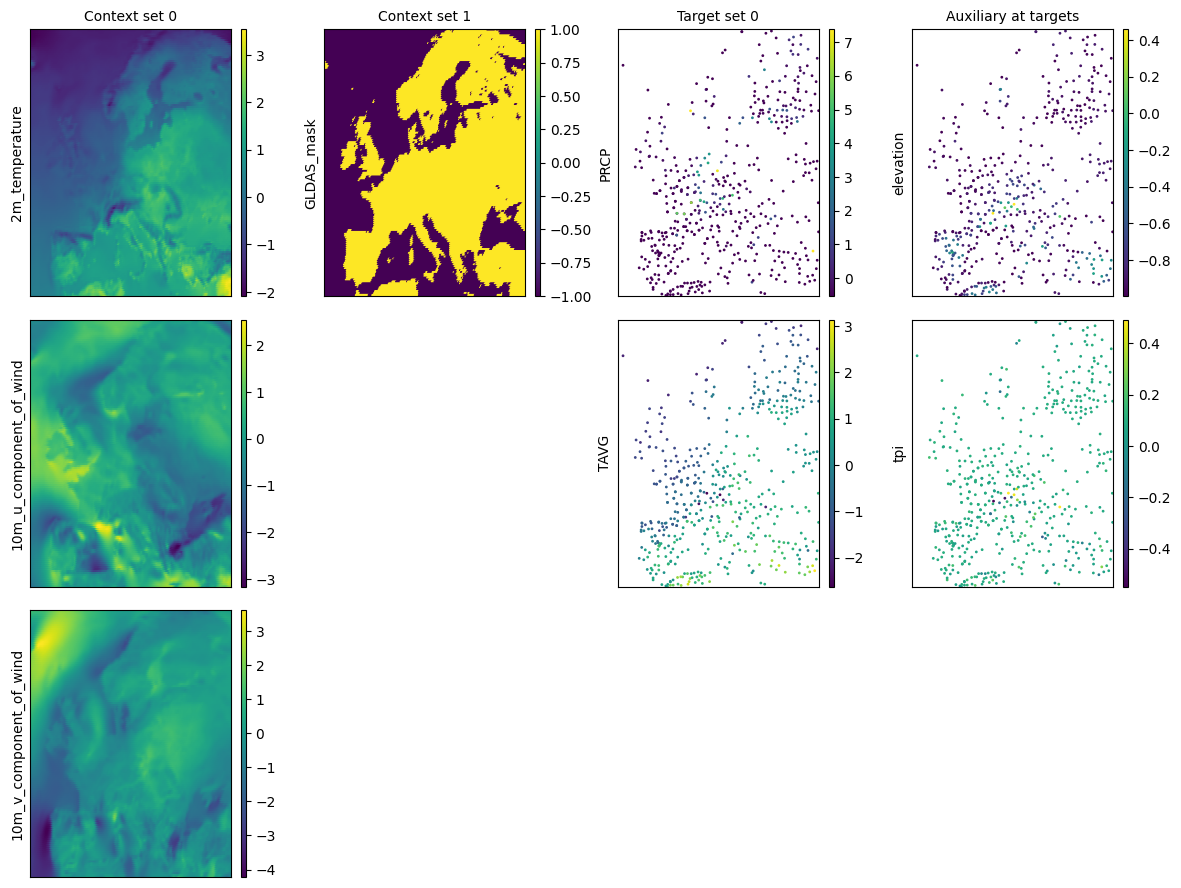

In [36]:
fig = deepsensor.plot.task(task, task_loader)
plt.show()

### Spatial Interpolation.
Spatial interpolation tasks can be generated either from:

gridded xarray data, by randomly sampling points from the grid, or

pointwise pandas data, by randomly splitting the data into context and target sets.

### Interpolating Gridded Xarray data
* randomly sampling a float fraction of points


In [37]:
task_loader = TaskLoader(context=era5_ds["2m_temperature"], target=era5_ds["2m_temperature"])
task = task_loader("2016-06-28", context_sampling=0.03, target_sampling="all")
print(task)

time: 2016-06-28 00:00:00
ops: []
X_c: [(2, 934)]
Y_c: [(1, 934)]
X_t: [((1, 141), (1, 221))]
Y_t: [(1, 141, 221)]



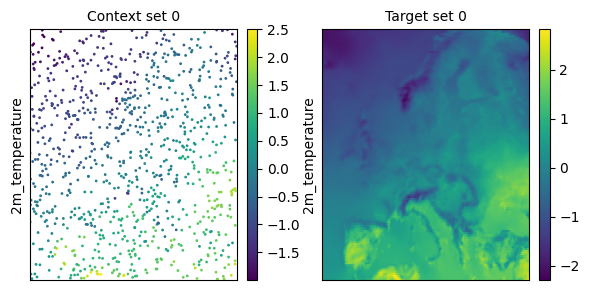

In [38]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Randomly sampling a Int no of pts

In [39]:
task = task_loader("2016-06-25", context_sampling=100, target_sampling=1000)
print(task)

time: 2016-06-25 00:00:00
ops: []
X_c: [(2, 100)]
Y_c: [(1, 100)]
X_t: [(2, 1000)]
Y_t: [(1, 1000)]



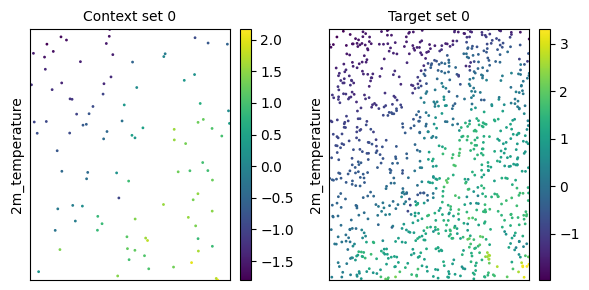

In [40]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Interpolating pointwise pandas data.

In [41]:
station_df

PRCP      TAVG
time       x1       x2       station                        
2016-06-25 0.000309 0.246364 AGM00060531 -0.537265  1.070514
           0.001818 0.239091 AGE00147716 -0.537265  0.519380
           0.002127 0.940909 SYM00040030       NaN  2.566449
           0.003036 0.314855 AGM00060514 -0.537265  2.192465
           0.003636 0.261509 AGM00060520 -0.537265  1.956265
...                                            ...       ...
2016-06-30 0.346784 0.496829 GME00123058 -0.517511       NaN
           0.051818 0.779091 TUM00017234       NaN  1.877532
           0.191455 0.430345 ITM00016064 -0.478003  1.011464
           0.635955 0.697420 NOE00133110 -0.537265       NaN
           0.452844 0.463924 NOE00132930  1.062807       NaN

[16556 rows x 2 columns]

In [ ]:
station_df.loc[pd.to_datetime("2016-06-25")].dropna()

,,,PRCP,TAVG
x1,x2,station,,
0.000309,0.246364,AGM00060531,-0.537265,1.070514
0.001818,0.239091,AGE00147716,-0.537265,0.519380
0.003036,0.314855,AGM00060514,-0.537265,2.192465
0.003636,0.261509,AGM00060520,-0.537265,1.956265
0.003782,0.275400,AGM00060507,-0.537265,1.779115
...,...,...,...,...
0.621818,0.910909,RSM00022028,-0.181694,-1.960724
0.626605,0.736398,NOE00105498,-0.537265,-1.665474
0.630071,0.616875,NO000001026,-0.418741,-2.177241


In [54]:
task_loader = TaskLoader(context=station_df["TAVG"], target=station_df["TAVG"], links=[(0, 0)])

In [55]:
print(task_loader)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('TAVG',),)
Target variable IDs: (('TAVG',),)


In [57]:
task = task_loader("2016-06-25", context_sampling="split", target_sampling="split", split_frac=0.1)
print(task)

time: 2016-06-25 00:00:00
ops: []
X_c: [(2, 67)]
Y_c: [(1, 67)]
X_t: [(2, 597)]
Y_t: [(1, 597)]



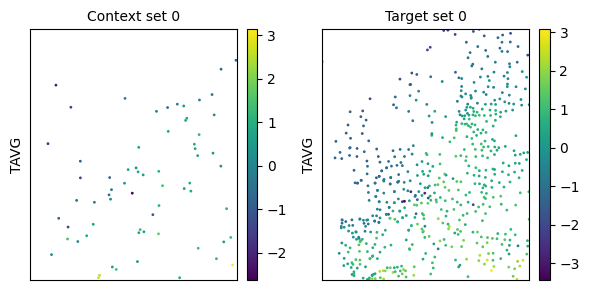

In [58]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Forecasting
* context_delta_t and/or target_delta_t, can generate tasks for forecasting.

In [59]:
task_loader = TaskLoader(
    context=[era5_ds["2m_temperature"],] * 3,
    context_delta_t=[-1, -2, 0],
    target=era5_ds["2m_temperature"],
    target_delta_t=1,
    time_freq="D",  # daily frequency (the default)
)
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('2m_temperature',), ('2m_temperature',))
Target variable IDs: (('2m_temperature',),)


In [14]:
task = task_loader("2016-06-27", context_sampling="all", target_sampling="all")
print(task)

time: 2016-06-27 00:00:00
ops: []
X_c: [((1, 141), (1, 221)), ((1, 141), (1, 221)), ((1, 141), (1, 221))]
Y_c: [(1, 141, 221), (1, 141, 221), (1, 141, 221)]
X_t: [((1, 141), (1, 221))]
Y_t: [(1, 141, 221)]



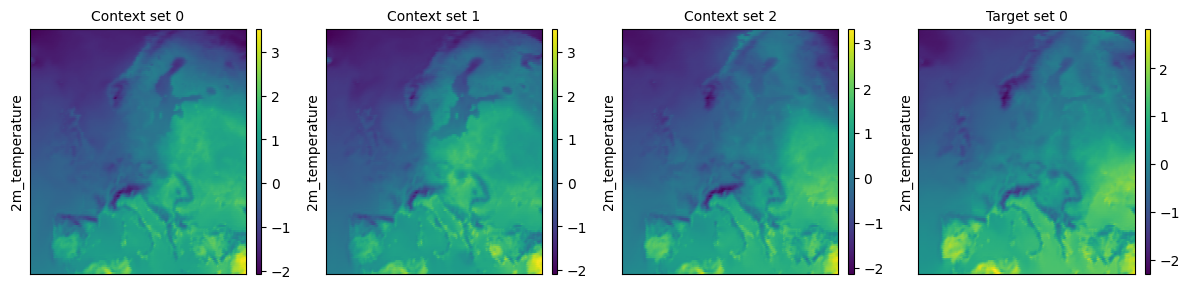

In [15]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Downscaling
* learn a mapping from coarse gridded data to localised observations.
* with the right auxiliary information and enough data, a model can distinguish between an observation from the top of mountain vs a valley, vs a city vs a field.

In [16]:
task_loader = TaskLoader(
    context=[era5_ds["2m_temperature"], land_mask_ds],
    target=station_df["TAVG"],
    aux_at_targets=aux_ds,
)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',))
Target variable IDs: (('TAVG',),)
Auxiliary-at-target variable IDs: ('elevation', 'tpi')


In [18]:
task = task_loader("2016-06-25", context_sampling="all", target_sampling="all")
print(task)

time: 2016-06-25 00:00:00
ops: []
X_c: [((1, 141), (1, 221)), ((1, 140), (1, 220))]
Y_c: [(1, 141, 221), (1, 140, 220)]
X_t: [(2, 664)]
Y_t: [(1, 664)]
Y_t_aux: (2, 664)



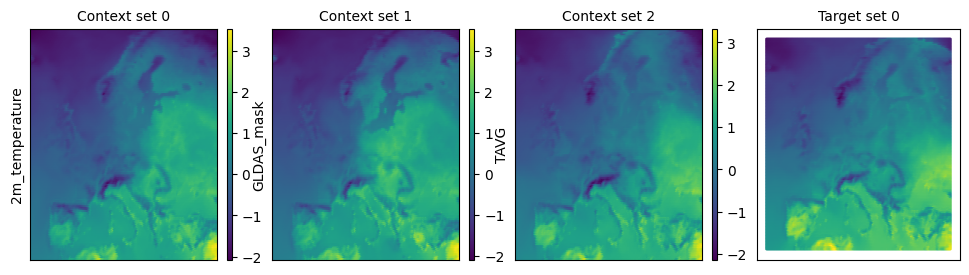

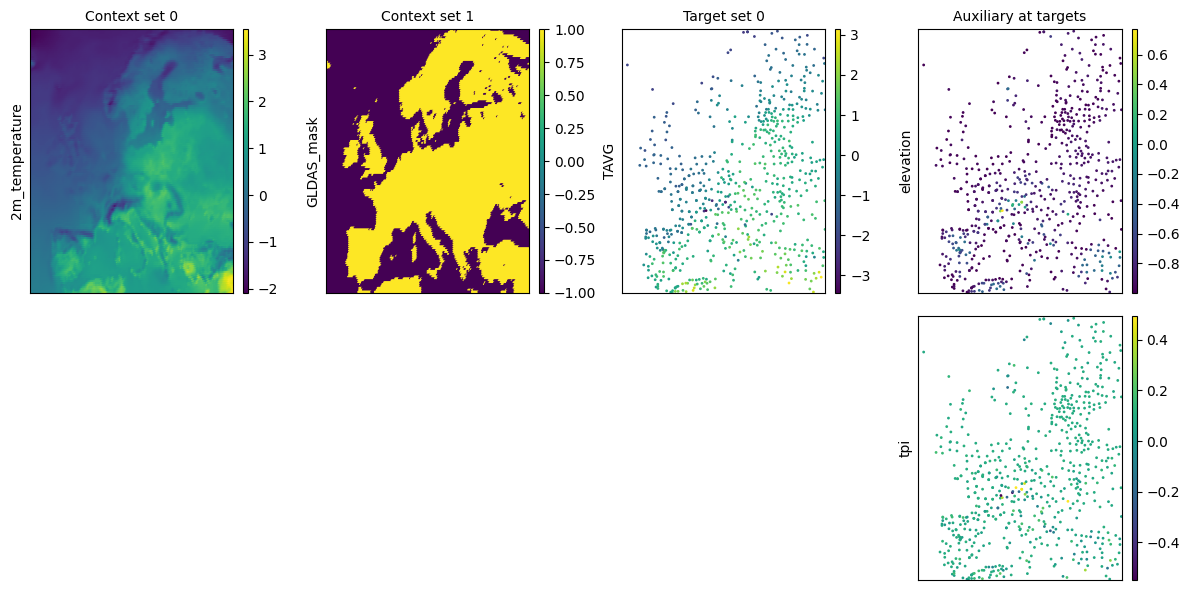

In [19]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Gap Filling.
* tasks for filling missing data gaps in xarray object.
* gen fake missing data, normalised temp values below -0.75 to NaN.
* In practical it could be missing due to cloud coverage, satellite orbit gaps, sensor issues or other reasons.

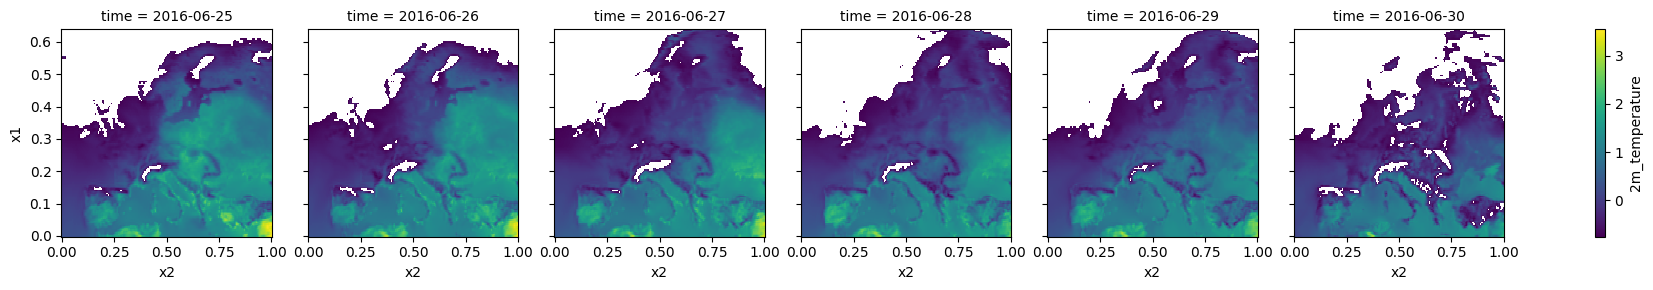

In [20]:
era5_gappy_ds = era5_ds["2m_temperature"].where(era5_ds["2m_temperature"] > -0.75)
fig = era5_gappy_ds.plot(col="time", col_wrap=6, center=False)
plt.show()

### If we pass the gapfill to context_set and target set arguments, taskloader does the following.
*  randomly samples the missing data mask from other time slice.
* adds this new mask to the context set(increasing the amount of missing data in the context set)
* the context points which were just removed by the new mask becomes the target set.
* This may produce NANs in the target set, due to overlap b/w the new mask and original mask. 
* To remove these NaNs, use the Task.remove_context_nans and Task.remove_target_nans methods.

In [21]:
task_loader = TaskLoader(context=era5_gappy_ds, target=era5_gappy_ds, links=[(0, 0)])
task = task_loader("2016-06-25", context_sampling="gapfill", target_sampling="gapfill")
print(task.remove_context_nans().remove_target_nans())

time: 2016-06-25 00:00:00
ops: ['context_nans_removed', 'target_nans_removed']
X_c: [(2, 22795)]
Y_c: [(1, 22795)]
X_t: [(2, 1101)]
Y_t: [(1, 1101)]



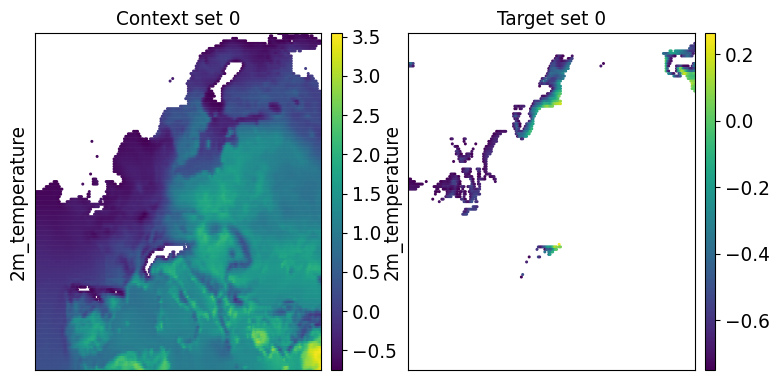

In [22]:
deepsensor.plot.task(task, task_loader, figsize=4)
plt.show()

### Once a model is trained with Tasks generated with the "gapfill" strategy, the model can be used to fill real missing data by passing "all" for context_sampling.

### Combination of Data Fusion Tasks.
* combining forecasting with downscaling. 

In [23]:
task_loader = TaskLoader(
    context=[era5_ds["2m_temperature"], era5_ds["2m_temperature"], land_mask_ds],
    context_delta_t=[-1, -2, 0],
    target=station_df["TAVG"],
    target_delta_t=1,
    aux_at_targets=aux_ds,
)
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('2m_temperature',), ('GLDAS_mask',))
Target variable IDs: (('TAVG',),)
Auxiliary-at-target variable IDs: ('elevation', 'tpi')


In [24]:
task = task_loader("2016-06-28", context_sampling="all", target_sampling="all")
print(task)

time: 2016-06-28 00:00:00
ops: []
X_c: [((1, 141), (1, 221)), ((1, 141), (1, 221)), ((1, 140), (1, 220))]
Y_c: [(1, 141, 221), (1, 141, 221), (1, 140, 220)]
X_t: [(2, 667)]
Y_t: [(1, 667)]
Y_t_aux: (2, 667)



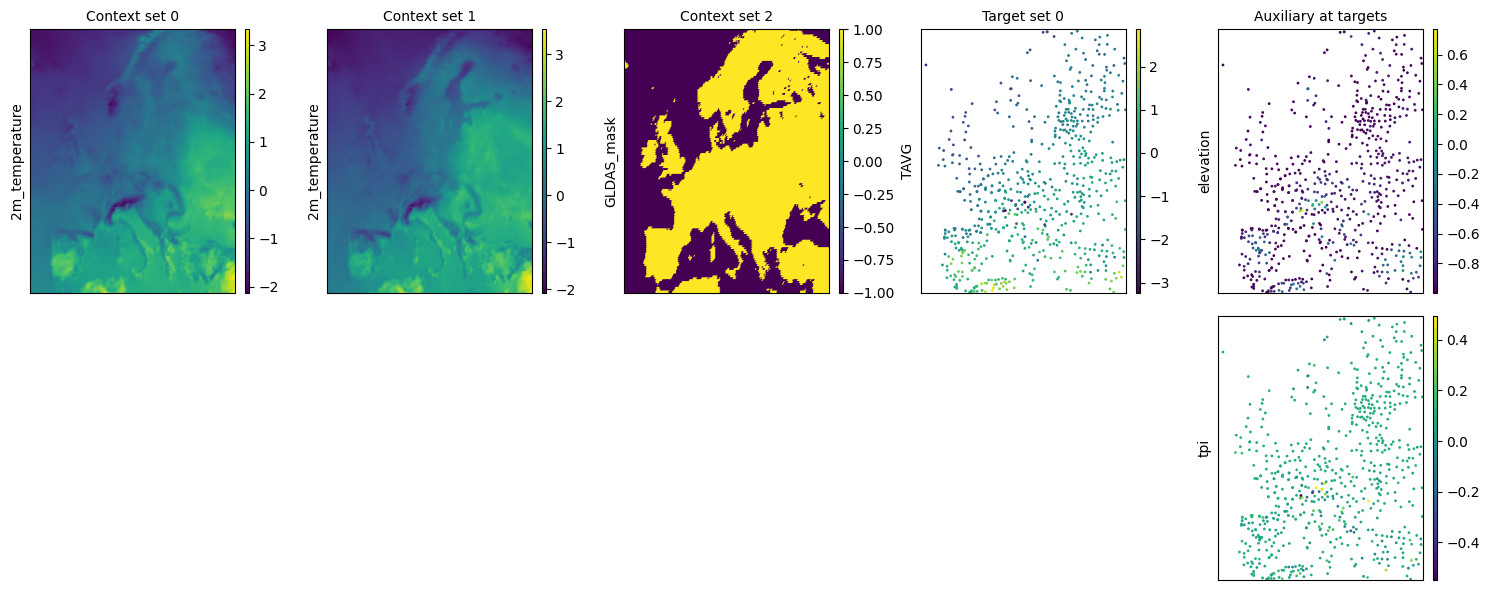

In [25]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Controlling randomness in the Taskloader 
* datewise_deterministic = if true, the same random seed will be used for a particular date.
* generating a reproducible validation set which is same between python sessions.
* seed_override = if not none, this seed will be used instead of the default seed.

In [26]:
data_fpath = "tmp.nc"
era5_ds.to_netcdf(data_fpath)

In [27]:
task_loader = TaskLoader(context=data_fpath, target=data_fpath)
print(task_loader)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'),)
Target variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'),)


### Saving and loading the Taskloader.

In [28]:
task_loader.save("tmp/")

In [29]:
task_loader_loaded = TaskLoader("tmp/")
print(task_loader_loaded)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'),)
Target variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'),)


In [30]:
import os
import shutil
os.remove(data_fpath)
shutil.rmtree("tmp/")